# Script to integrate GALAH spectra

## Author: Sven Buder (SB, MPIA) buder at mpia dot de

This script is intended to integrate the 4 spectra of the arms of the HERMES spectrograph while mimicking the observation from a large vertical distance (0,0,Z) with respect to the Galactic plane

History:
    190118 - SB created

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
import os
import pandas
import astropy.io.fits as pyfits
from astropy.table import Table
import matplotlib.pyplot as plt

# Adjust directory you want to work in
working_directory = '/shared-storage/buder/svn-repos/trunk/GALAH/'
os.chdir(working_directory)

/usr/lib64/python2.7/site-packages/gtk-2.0/gtk/__init__.py:57: GtkWarning: could not open display
  warnings.warn(str(e), _gtk.Warning)


### Select spectra that will be integrated

In [2]:
galah_input = pyfits.getdata('DATA/sobject_iraf_53_2MASS_GaiaDR2_WISE_PanSTARRSDR1_BailerJones_K2seis.fits',1)

In [3]:
# VJK = K + 2*(J - K + 0.14) + 0.382 * exp((J-K-0.2)/0.5)
v_jk_mag = galah_input['ks_m'] + 2*(galah_input['j_m'] - galah_input['ks_m'] + 0.14) + 0.382 * np.exp((galah_input['j_m']-galah_input['ks_m']-0.2)/0.5)

In [4]:
v_jk_9_12 = (v_jk_mag >= 9) & (v_jk_mag < 12)
v_jk_12_14 = (v_jk_mag >= 12) & (v_jk_mag < 14)

/home/buder/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/home/buder/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/buder/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/home/buder/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [5]:
dynamics = pyfits.getdata('GALAH_DR3/dynamics/sobject_dynamics.fits',1)

useful_spectra_9_12 = np.isfinite(dynamics['vz_Rzphi']) & v_jk_9_12
sobject_id_9_12 = dynamics['sobject_id'][useful_spectra_9_12]
v_z_9_12 = dynamics['vz_Rzphi'][useful_spectra_9_12]
rv_9_12 = galah_input['rv_guess_shift'][useful_spectra_9_12]

useful_spectra_12_14 = np.isfinite(dynamics['vz_Rzphi']) & v_jk_12_14
sobject_id_12_14 = dynamics['sobject_id'][useful_spectra_12_14]
v_z_12_14 = dynamics['vz_Rzphi'][useful_spectra_12_14]
rv_12_14 = galah_input['rv_guess_shift'][useful_spectra_12_14]

dynamics = []

### Definitions which will be executed in the last cell

In [6]:
def read_spectra(sobject_id, v_z, rv, iraf_dr = 'dr5.3', SPECTRA = 'SPECTRA'):
    """
    This function reads in the 4 individual spectra from the subdirectory working_directory/SPECTRA
    
    INPUT:
    sobject_id = identifier of spectra by date (6digits), plate (4digits), combination (2digits) and pivot number (3digits)
    iraf_dr = reduction which shall be used, current version: dr5.3
    SPECTRA = string to indicate sub directory where spectra are saved
    
    OUTPUT
    spectrum = dictionary
    """
    
    spectrum = dict(sobject_id = sobject_id)
    
    # Assess if spectrum is stacked
    if str(sobject_id)[11] == '1':
        # Single observations are saved in 'com'
        com='com'
    else:
        # Stacked observations are saved in 'com2'
        com='com'   
    
    # Iterate through all 4 CCDs
    for each_ccd in [1,2,3,4]:
        
        fits = pyfits.open(SPECTRA+'/'+iraf_dr+'/'+str(sobject_id)[0:6]+'/standard/'+com+'/'+str(sobject_id)+str(each_ccd)+'.fits')

        # Extension 0: Reduced spectrum
        # Extension 1: Relative error spectrum
        # Extension 4: Normalised spectrum, NB: cut for CCD4

        # Extract wavelength grid for the normalised spectrum
        start_wavelength = fits[0].header["CRVAL1"]
        dispersion       = fits[0].header["CDELT1"]
        nr_pixels        = fits[0].header["NAXIS1"]
        reference_pixel  = fits[0].header["CRPIX1"]
        if reference_pixel == 0:
            reference_pixel=1
            
        lambda_0 = np.array(map(lambda x:((x-reference_pixel+1)*dispersion+start_wavelength),range(0,nr_pixels)))
        
        spectrum['wave_norm_'+str(each_ccd)] = lambda_0 * (1. - rv/299792.) * (1. + v_z/299792.)
        
        # Extract flux and flux error of reduced spectrum
        spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[0].data)
        if each_ccd != 4:
            spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[0].data * fits[1].data)
        else:
            # for normalised error of CCD4, only used appropriate parts of error spectrum
            spectrum['uob_norm_4'] = np.array(fits[0].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])
            
        fits.close()
        
    return spectrum

In [7]:
# The integrated wavelength grid as used for GALAH DR2
wave_integrated = dict()
wave_integrated['ccd1'] = np.arange(4715.94,4896.00,0.046)
wave_integrated['ccd2'] = np.arange(5650.06,5868.25,0.055)
wave_integrated['ccd3'] = np.arange(6480.52,6733.92,0.064)
wave_integrated['ccd4'] = np.arange(7693.50,7875.55,0.074)

In [8]:
def interpolate_spectrum_onto_same_wavelength(spectrum, wave_integrated = wave_integrated):
    """
    This function interpolates the spectrum 
    onto the wavelength grid of The Cannon as used for GALAH DR2
    
    INPUT:
    spectrum dictionary
    
    OUTPUT:
    interpolated spectrum dictionary
    
    """
    
    # Initialise interpolated spectrum from input spectrum
    interpolated_spectrum = dict()
    for each_key in spectrum.keys():
        interpolated_spectrum[each_key] = spectrum[each_key]
    
    for each_ccd in [1, 2, 3, 4]:
        
        # exchange wavelength
        interpolated_spectrum['wave_norm_'+str(each_ccd)] = wave_integrated['ccd'+str(each_ccd)]
        
        # interpolate and exchange flux
        interpolated_spectrum['sob_norm_'+str(each_ccd)]  = np.interp(
            wave_integrated['ccd'+str(each_ccd)],
            spectrum['wave_norm_'+str(each_ccd)],
            spectrum['sob_norm_'+str(each_ccd)],
            )

        # interpolate and exchange flux error
        interpolated_spectrum['uob_norm_'+str(each_ccd)]  = np.interp(
            wave_integrated['ccd'+str(each_ccd)],
            spectrum['wave_norm_'+str(each_ccd)],
            spectrum['uob_norm_'+str(each_ccd)],
            )

    return interpolated_spectrum

In [9]:
wave_min = {}
wave_max = {}
wave_min['ccd1'] = []
wave_min['ccd2'] = []
wave_min['ccd3'] = []
wave_min['ccd4'] = []
wave_max['ccd1'] = []
wave_max['ccd2'] = []
wave_max['ccd3'] = []
wave_max['ccd4'] = []

sob_integrated = {}
uob_integrated = {}

for each_ccd in [1,2,3,4]:
    sob_integrated['ccd'+str(each_ccd)] = []
    uob_integrated['ccd'+str(each_ccd)] = []
    
nr_spectra_useful = 0

for (each_sobject_id, each_vz, each_rv) in zip(sobject_id_9_12, v_z_9_12, rv_9_12):
    try:
        spectrum = read_spectra(each_sobject_id, each_vz, each_rv)
        for each_ccd in [1,2,3,4]:
            wave_min['ccd'+str(each_ccd)].append(np.min(spectrum['wave_norm_'+str(each_ccd)]))
            wave_max['ccd'+str(each_ccd)].append(np.max(spectrum['wave_norm_'+str(each_ccd)]))

        inerpolated_spectrum = interpolate_spectrum_onto_same_wavelength(spectrum)

        for each_ccd in [1,2,3,4]:

            clipped = inerpolated_spectrum['sob_norm_'+str(each_ccd)]
            #clipped.clip(min=0., max=1.3, out=clipped)

            sob_integrated['ccd'+str(each_ccd)].append(clipped)
            uob_integrated['ccd'+str(each_ccd)].append(inerpolated_spectrum['uob_norm_'+str(each_ccd)])

        nr_spectra_useful+=1

    except:
        pass

In [10]:
for each_entry in wave_min.keys():
    np.savetxt('check_wave_min_'+each_entry+'_9_12.txt',np.percentile(wave_min[each_entry],q=[0,5,16,50,84,95,100]))
for each_entry in wave_max.keys():
    np.savetxt('check_wave_max_'+each_entry+'_9_12.txt',np.percentile(wave_max[each_entry],q=[0,5,16,50,84,95,100]))

In [11]:
median_flux = {}
mean_flux = {}
integrated_flux = {}
integrated_flux_error = {}
release_data = {}

for each_ccd in [1,2,3,4]:
    sob_integrated['ccd'+str(each_ccd)] = np.array(sob_integrated['ccd'+str(each_ccd)])
    uob_integrated['ccd'+str(each_ccd)] = np.array(uob_integrated['ccd'+str(each_ccd)])
    
    mean_flux['ccd'+str(each_ccd)] = np.array([np.mean(sob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(sob_integrated['ccd'+str(each_ccd)])[1])])
    median_flux['ccd'+str(each_ccd)] = np.array([np.median(sob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(sob_integrated['ccd'+str(each_ccd)])[1])])
    integrated_flux['ccd'+str(each_ccd)] = np.array([np.sum(sob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(sob_integrated['ccd'+str(each_ccd)])[1])])
    integrated_flux_error['ccd'+str(each_ccd)] = np.array([np.sum(uob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(uob_integrated['ccd'+str(each_ccd)])[1])])

release_data['wavelength'] = np.concatenate(([wave_integrated['ccd1'],wave_integrated['ccd2'],wave_integrated['ccd3'],wave_integrated['ccd4']]))
release_data['integrated_flux'] = np.concatenate(([integrated_flux['ccd1'],integrated_flux['ccd2'],integrated_flux['ccd3'],integrated_flux['ccd4']]))
release_data['integrated_flux_error'] = np.concatenate(([integrated_flux_error['ccd1'],integrated_flux_error['ccd2'],integrated_flux_error['ccd3'],integrated_flux_error['ccd4']]))
release_data['mean_flux'] = np.concatenate(([mean_flux['ccd1'],mean_flux['ccd2'],mean_flux['ccd3'],mean_flux['ccd4']]))
release_data['median_flux'] = np.concatenate(([median_flux['ccd1'],median_flux['ccd2'],median_flux['ccd3'],median_flux['ccd4']]))

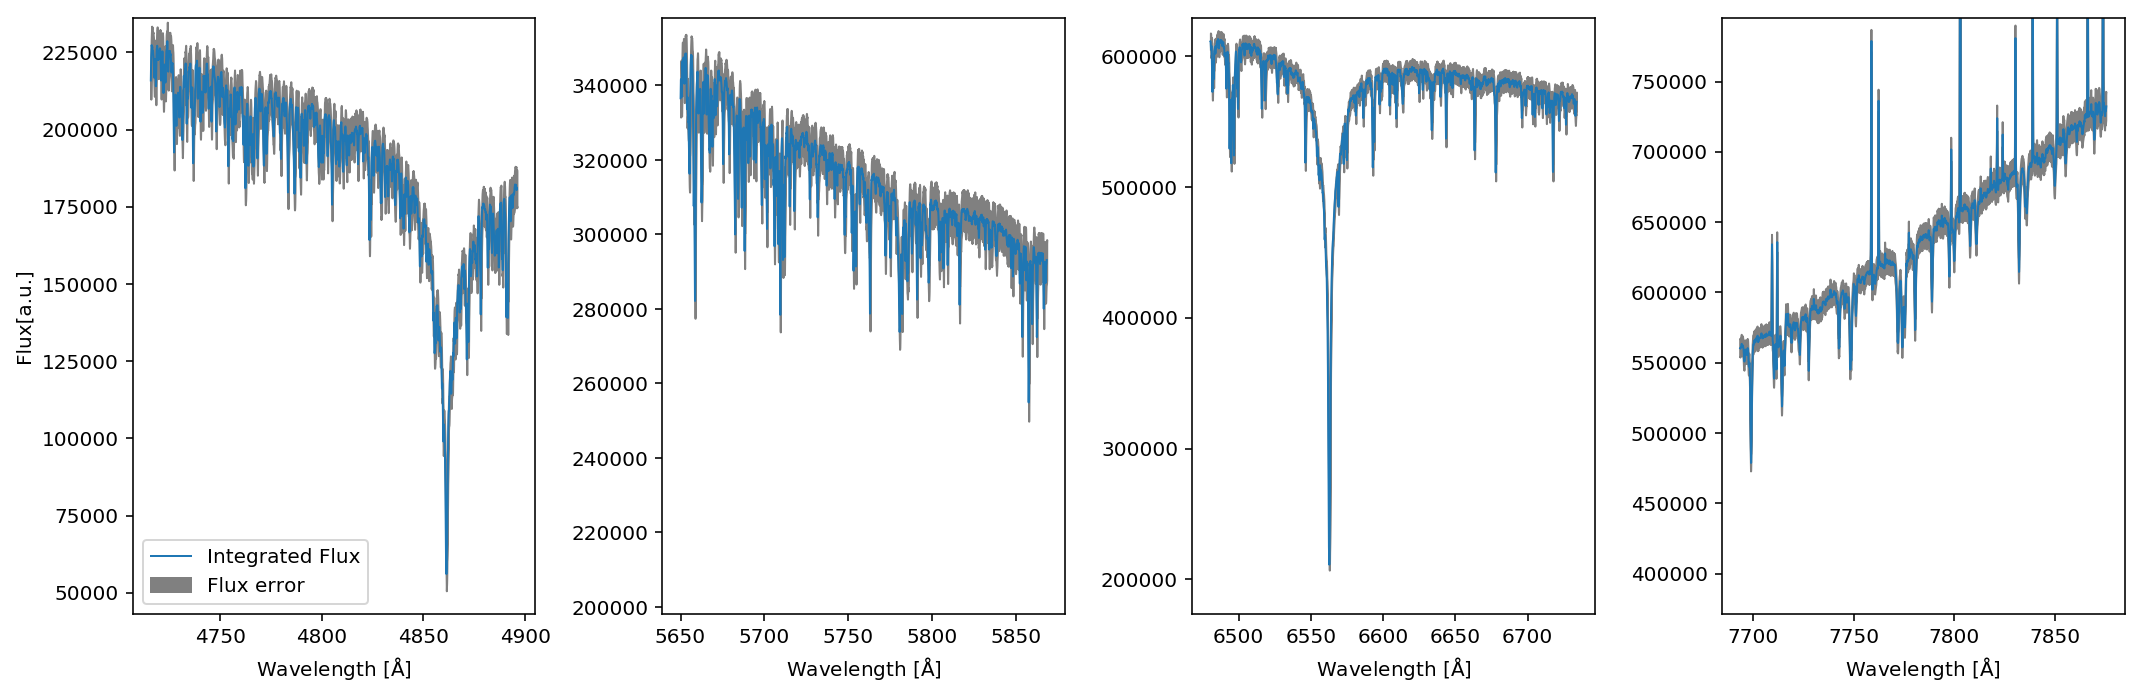

In [12]:
plt.figure(figsize=(15,5))

for each_ccd in [1,2,3,4]:
    ax = plt.subplot(1,4,each_ccd)
    
#     ax.plot(
#         wave_integrated['ccd'+str(each_ccd)],
#         mean_flux['ccd'+str(each_ccd)],
#         label='Mean Flux'
#     )
#     ax.plot(
#         wave_integrated['ccd'+str(each_ccd)],
#         median_flux['ccd'+str(each_ccd)],
#         label='Median Flux'
#     )
    ax.plot(
        wave_integrated['ccd'+str(each_ccd)],
        integrated_flux['ccd'+str(each_ccd)],
        label='Integrated Flux',
        zorder=2,
        lw=1
    )
    ax.fill_between(
        wave_integrated['ccd'+str(each_ccd)],
        integrated_flux['ccd'+str(each_ccd)]-integrated_flux_error['ccd'+str(each_ccd)],
        integrated_flux['ccd'+str(each_ccd)]+integrated_flux_error['ccd'+str(each_ccd)],
        label='Flux error',
        color='gray',
        zorder=1
    )
    if each_ccd == 1:
        ax.set_ylabel('Flux[a.u.]')
    #else:
    #    ax.set_yticks([])
    ax.set_xlabel(r'Wavelength [$\mathrm{\AA}$]')
    ax.set_ylim(
        np.percentile(0.75*integrated_flux['ccd'+str(each_ccd)]-integrated_flux_error['ccd'+str(each_ccd)],q=[0.25]),
        np.percentile(1.02*integrated_flux['ccd'+str(each_ccd)]+integrated_flux_error['ccd'+str(each_ccd)],q=[99])
    )
    if each_ccd == 1:
        ax.legend(loc='lower left')
plt.tight_layout(h_pad=0.)
plt.savefig('GALAH_DR3/science/Mass_assembly/Integrated_GALAH_9_12_spectrum_XYZ_i0deg.pdf')

release_pandas = pandas.DataFrame(release_data,columns=release_data.keys())
release_astropy = Table.from_pandas(release_pandas)
release_astropy.write('GALAH_DR3/science/Mass_assembly/Integrated_GALAH_9_12_spectrum_XYZ_i0deg.fits',overwrite=True)

In [18]:
wave_min = {}
wave_max = {}
wave_min['ccd1'] = []
wave_min['ccd2'] = []
wave_min['ccd3'] = []
wave_min['ccd4'] = []
wave_max['ccd1'] = []
wave_max['ccd2'] = []
wave_max['ccd3'] = []
wave_max['ccd4'] = []

sob_integrated = {}
uob_integrated = {}

for each_ccd in [1,2,3,4]:
    sob_integrated['ccd'+str(each_ccd)] = []
    uob_integrated['ccd'+str(each_ccd)] = []
    
nr_spectra_useful = 0

for (each_sobject_id, each_vz, each_rv) in zip(sobject_id_12_14, v_z_12_14, rv_12_14):
    try:
        spectrum = read_spectra(each_sobject_id, each_vz, each_rv)
        for each_ccd in [1,2,3,4]:
            wave_min['ccd'+str(each_ccd)].append(np.min(spectrum['wave_norm_'+str(each_ccd)]))
            wave_max['ccd'+str(each_ccd)].append(np.max(spectrum['wave_norm_'+str(each_ccd)]))

        inerpolated_spectrum = interpolate_spectrum_onto_same_wavelength(spectrum)

        for each_ccd in [1,2,3,4]:

            clipped = inerpolated_spectrum['sob_norm_'+str(each_ccd)]
            #clipped.clip(min=0., max=1.3, out=clipped)

            sob_integrated['ccd'+str(each_ccd)].append(clipped)
            uob_integrated['ccd'+str(each_ccd)].append(inerpolated_spectrum['uob_norm_'+str(each_ccd)])

        nr_spectra_useful+=1

    except:
        pass

In [19]:
for each_entry in wave_min.keys():
    np.savetxt('check_wave_min_'+each_entry+'_12_14.txt',np.percentile(wave_min[each_entry],q=[0,5,16,50,84,95,100]))
for each_entry in wave_max.keys():
    np.savetxt('check_wave_max_'+each_entry+'_12_14.txt',np.percentile(wave_max[each_entry],q=[0,5,16,50,84,95,100]))

In [20]:
median_flux = {}
mean_flux = {}
integrated_flux = {}
integrated_flux_error = {}
release_data = {}

for each_ccd in [1,2,3,4]:
    sob_integrated['ccd'+str(each_ccd)] = np.array(sob_integrated['ccd'+str(each_ccd)])
    uob_integrated['ccd'+str(each_ccd)] = np.array(uob_integrated['ccd'+str(each_ccd)])
    
    mean_flux['ccd'+str(each_ccd)] = np.array([np.mean(sob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(sob_integrated['ccd'+str(each_ccd)])[1])])
    median_flux['ccd'+str(each_ccd)] = np.array([np.median(sob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(sob_integrated['ccd'+str(each_ccd)])[1])])
    integrated_flux['ccd'+str(each_ccd)] = np.array([np.sum(sob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(sob_integrated['ccd'+str(each_ccd)])[1])])
    integrated_flux_error['ccd'+str(each_ccd)] = np.array([np.sum(uob_integrated['ccd'+str(each_ccd)][:,x]) for x in range(np.shape(uob_integrated['ccd'+str(each_ccd)])[1])])

release_data['wavelength'] = np.concatenate(([wave_integrated['ccd1'],wave_integrated['ccd2'],wave_integrated['ccd3'],wave_integrated['ccd4']]))
release_data['integrated_flux'] = np.concatenate(([integrated_flux['ccd1'],integrated_flux['ccd2'],integrated_flux['ccd3'],integrated_flux['ccd4']]))
release_data['integrated_flux_error'] = np.concatenate(([integrated_flux_error['ccd1'],integrated_flux_error['ccd2'],integrated_flux_error['ccd3'],integrated_flux_error['ccd4']]))
release_data['mean_flux'] = np.concatenate(([mean_flux['ccd1'],mean_flux['ccd2'],mean_flux['ccd3'],mean_flux['ccd4']]))
release_data['median_flux'] = np.concatenate(([median_flux['ccd1'],median_flux['ccd2'],median_flux['ccd3'],median_flux['ccd4']]))

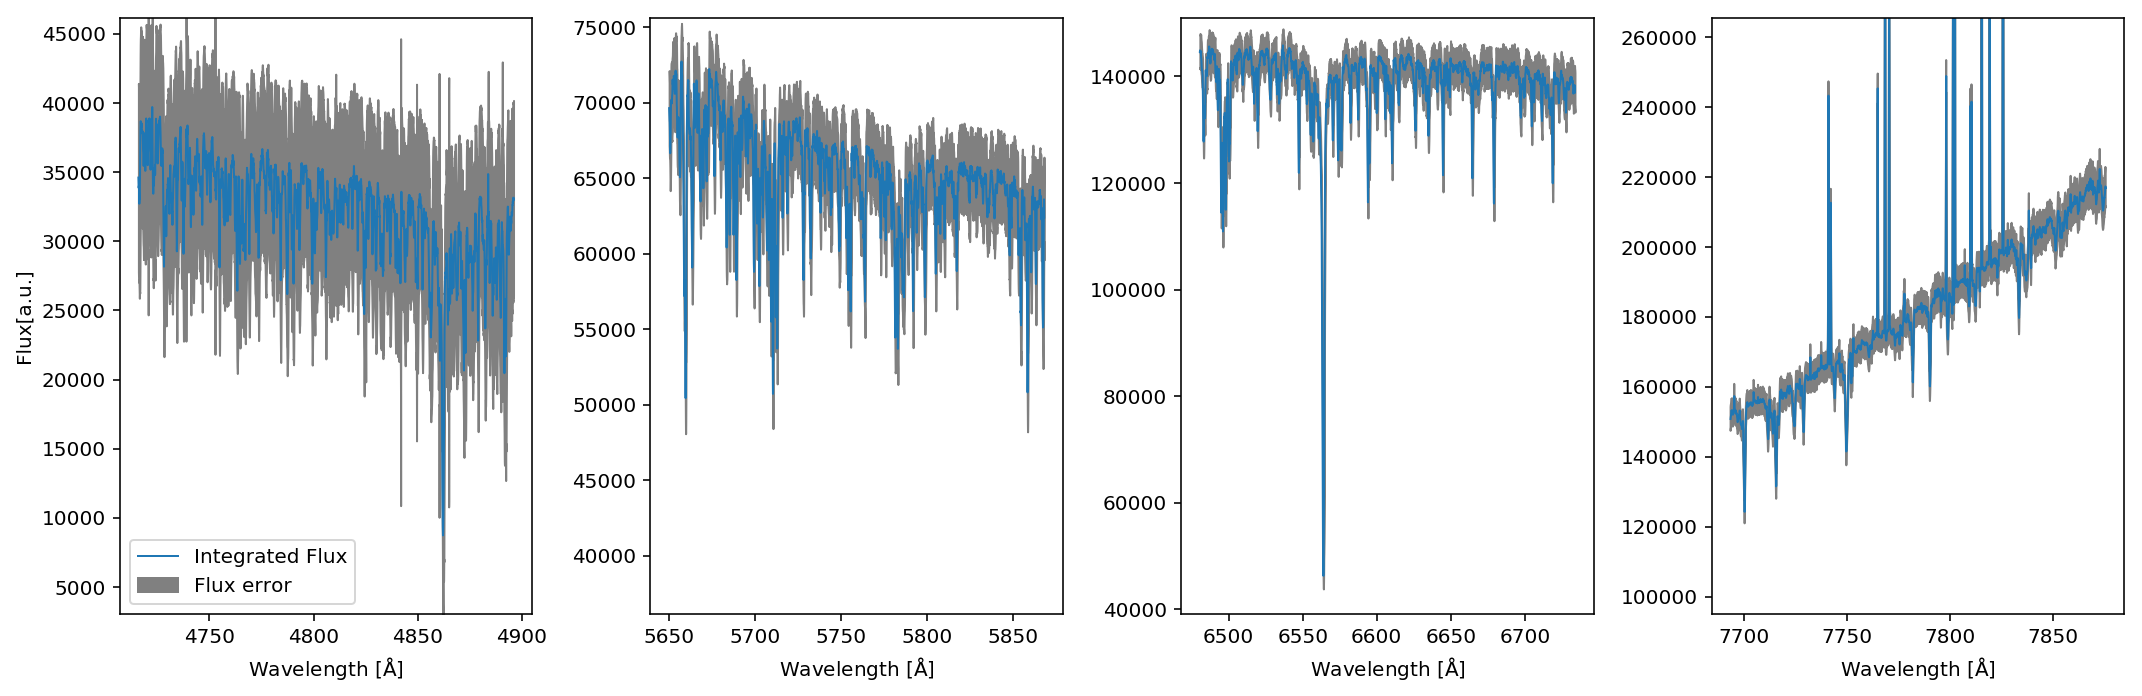

In [21]:
plt.figure(figsize=(15,5))

for each_ccd in [1,2,3,4]:
    ax = plt.subplot(1,4,each_ccd)
    
#     ax.plot(
#         wave_integrated['ccd'+str(each_ccd)],
#         mean_flux['ccd'+str(each_ccd)],
#         label='Mean Flux'
#     )
#     ax.plot(
#         wave_integrated['ccd'+str(each_ccd)],
#         median_flux['ccd'+str(each_ccd)],
#         label='Median Flux'
#     )
    ax.plot(
        wave_integrated['ccd'+str(each_ccd)],
        integrated_flux['ccd'+str(each_ccd)],
        label='Integrated Flux',
        zorder=2,
        lw=1
    )
    ax.fill_between(
        wave_integrated['ccd'+str(each_ccd)],
        integrated_flux['ccd'+str(each_ccd)]-integrated_flux_error['ccd'+str(each_ccd)],
        integrated_flux['ccd'+str(each_ccd)]+integrated_flux_error['ccd'+str(each_ccd)],
        label='Flux error',
        color='gray',
        zorder=1
    )
    if each_ccd == 1:
        ax.set_ylabel('Flux[a.u.]')
    #else:
    #    ax.set_yticks([])
    ax.set_xlabel(r'Wavelength [$\mathrm{\AA}$]')
    ax.set_ylim(
        np.percentile(0.75*integrated_flux['ccd'+str(each_ccd)]-integrated_flux_error['ccd'+str(each_ccd)],q=[0.25]),
        np.percentile(1.02*integrated_flux['ccd'+str(each_ccd)]+integrated_flux_error['ccd'+str(each_ccd)],q=[99])
    )
    if each_ccd == 1:
        ax.legend(loc='lower left')
plt.tight_layout(h_pad=0.)
plt.savefig('GALAH_DR3/science/Mass_assembly/Integrated_GALAH_12_14_spectrum_XYZ_i0deg.pdf')

release_pandas = pandas.DataFrame(release_data,columns=release_data.keys())
release_astropy = Table.from_pandas(release_pandas)
release_astropy.write('GALAH_DR3/science/Mass_assembly/Integrated_GALAH_12_14_spectrum_XYZ_i0deg.fits',overwrite=True)

In [17]:
import smtplib

sender = 'buder@mpia.de'
receivers = ['buder@mpia.de']

message = """From: Gemini2
To: buder@mpia.de
Subject: Integrating spectra finished
"""

try:
    smtpObj = smtplib.SMTP('localhost')
    smtpObj.sendmail(sender, receivers, message)         
    print("Successfully sent email")
except SMTPException:
    print("Error: unable to send email")

Successfully sent email
